# Multi-Output Stock Price Forecasting (7-Day Horizon)

## Overview
This notebook trains and evaluates regression models to predict the next 7 days of closing prices in a one-shot, multi-output setup.

### Key Goals:
- Train stock-agnostic models that generalize to unseen stocks
- Predict 7-day closing prices: [close_t+1, ..., close_t+7]
- Track experiments with MLflow
- Compare baseline and deep learning approaches

### Models Evaluated:
1. Baselines: Naive, Linear Regression, Random Forest, XGBoost
2. Deep Learning: LSTM, GRU, CNN+LSTM Hybrid
3. Time Series: Prophet (per-stock baseline)

---
## 1. Imports and Setup

In [1]:
# Standard libraries
import os
import glob
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Prophet
from prophet import Prophet

# Progress bars
from tqdm.auto import tqdm

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.keras
import mlflow.xgboost

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

2025-11-11 17:19:09.315408: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 17:19:09.408184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 17:19:15.465950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


All libraries imported successfully
TensorFlow version: 2.20.0
XGBoost version: 3.1.1


In [2]:
# Configuration
WINDOW_SIZE = 60          # Input: past 60 days of features
HORIZON = 7               # Output: predict next 7 days of closing prices
TEST_STOCK_RATIO = 0.2    # 20% of stocks reserved for testing (unseen stocks)
RANDOM_STATE = 42

# Paths
DATA_DIR = Path("data/processed/stock_data")
MODELS_DIR = Path("models")
MLFLOW_DIR = Path("mlruns")

# Create directories if needed
MODELS_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"MLflow tracking: {MLFLOW_DIR}")

Data directory: data/processed/stock_data
Models directory: models
MLflow tracking: mlruns


In [3]:
# MLflow Setup
mlflow.set_tracking_uri(f"file://{MLFLOW_DIR.absolute()}")
mlflow.set_experiment("stock-price-forecasting-7days")

experiment = mlflow.get_experiment_by_name("stock-price-forecasting-7days")
print(f"MLflow Experiment: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

MLflow Experiment: stock-price-forecasting-7days
Experiment ID: 839910380938886590
Artifact Location: file:///home/labeeb/Desktop/stock-curator/mlruns/839910380938886590


---
## 2. Load & Preprocess Data

In [4]:
# Load all stock CSV files
csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))

print(f"Found {len(csv_files)} stock CSV files")
print(f"\nFirst 5 files:")
for f in csv_files[:5]:
    print(f"  - {Path(f).name}")

Found 98 stock CSV files

First 5 files:
  - ABBOTINDIA_historical.csv
  - ABB_historical.csv
  - ADANIENT_historical.csv
  - ADANIGREEN_historical.csv
  - ADANIPORTS_historical.csv


In [5]:
def load_stock_data(file_path):
    """
    Load a single stock CSV and preprocess it.
    
    Args:
        file_path: Path to CSV file
    
    Returns:
        DataFrame with cleaned data, or None if insufficient data
    """
    df = pd.read_csv(file_path)
    
    # Parse date column
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Drop rows with NaN (due to indicator lag)
    df_clean = df.dropna()
    
    # Need at least WINDOW_SIZE + HORIZON rows for one sample
    if len(df_clean) < WINDOW_SIZE + HORIZON:
        return None
    
    return df_clean


# Load all stocks into a dictionary
stock_data = {}
skipped = []

for file_path in csv_files:
    symbol = Path(file_path).stem.replace('_historical', '')
    df = load_stock_data(file_path)
    
    if df is not None:
        stock_data[symbol] = df
    else:
        skipped.append(symbol)

print(f"Loaded {len(stock_data)} stocks successfully")
if skipped:
    print(f"Skipped {len(skipped)} stocks (insufficient data): {skipped}")

Loaded 98 stocks successfully


In [6]:
# Inspect data from one stock
sample_symbol = list(stock_data.keys())[0]
sample_df = stock_data[sample_symbol]

print(f"\nSample Stock: {sample_symbol}")
print(f"Shape: {sample_df.shape}")
print(f"Date Range: {sample_df['Date'].min()} to {sample_df['Date'].max()}")
print(f"\nColumns ({len(sample_df.columns)}):")
print(sample_df.columns.tolist())
print(f"\nFirst 3 rows:")
print(sample_df.head(3))


Sample Stock: ABBOTINDIA
Shape: (447, 28)
Date Range: 2024-01-15 00:00:00+05:30 to 2025-10-31 00:00:00+05:30

Columns (28):
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OI', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_SMA_20', 'Volume_Ratio', 'Daily_Return', 'Price_Range', 'Price_Change', 'Symbol', 'Name', 'ISIN']

First 3 rows:
                        Date     Open      High       Low     Close  Volume  \
49 2024-01-15 00:00:00+05:30  25700.0  26381.65  25700.00  26210.45   33616   
50 2024-01-16 00:00:00+05:30  26220.0  26305.90  25601.00  25806.50   51548   
51 2024-01-17 00:00:00+05:30  25600.0  26139.95  25546.15  25730.70   15925   

    OI     SMA_5     SMA_10      SMA_20  ...      BB_Upper      BB_Lower  \
49   0  25228.03  24418.650  23511.0825  ...  25865.034135  21157.130865   
50   0  25542.95  24666.575  23662.3925  ...  26200.405545  21124.379455   
51   0  25767

In [7]:
# Define feature columns (exclude metadata only)
# IMPORTANT: Close and technical indicators ARE included - this is CORRECT
# There is NO data leakage because:
#   - Input window: Past 60 days (Close_0 to Close_59)
#   - Target: Future 7 days (Close_60 to Close_66)
#   - No temporal overlap = proper autoregressive forecasting

exclude_cols = ['Date', 'Symbol', 'Name', 'ISIN']
feature_cols = [col for col in sample_df.columns if col not in exclude_cols]

print(f"\nFeature Columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Close is both a feature (for input window) and target (for prediction)
target_col = 'Close'
print(f"\nTarget Column: {target_col}")


Feature Columns (24):
   1. Open
   2. High
   3. Low
   4. Close
   5. Volume
   6. OI
   7. SMA_5
   8. SMA_10
   9. SMA_20
  10. SMA_50
  11. EMA_12
  12. EMA_26
  13. MACD
  14. MACD_Signal
  15. MACD_Hist
  16. RSI
  17. BB_Middle
  18. BB_Upper
  19. BB_Lower
  20. Volume_SMA_20
  21. Volume_Ratio
  22. Daily_Return
  23. Price_Range
  24. Price_Change

Target Column: Close


---
## 3. Create Sliding Windows & Train/Test Split

In [8]:
def create_sequences(df, window_size=60, horizon=7):
    """
    Create sliding window sequences for multi-output forecasting.
    
    Args:
        df: DataFrame with features
        window_size: Number of days to look back
        horizon: Number of days to predict ahead
    
    Returns:
        X: Array of shape (n_samples, window_size, n_features)
        y: Array of shape (n_samples, horizon) - closing prices for next 7 days
    """
    features = df[feature_cols].values
    target = df[target_col].values
    
    X, y = [], []
    
    # Slide window across time series
    for i in range(len(df) - window_size - horizon + 1):
        # Input: past window_size days of all features
        X.append(features[i:i + window_size])
        
        # Output: next horizon days of closing prices
        y.append(target[i + window_size:i + window_size + horizon])
    
    return np.array(X), np.array(y)


# Test on one stock
X_test_seq, y_test_seq = create_sequences(sample_df, WINDOW_SIZE, HORIZON)
print(f"\nTest Sequence Creation on {sample_symbol}:")
print(f"  Input shape (X):  {X_test_seq.shape}  -> (samples, window_size, features)")
print(f"  Output shape (y): {y_test_seq.shape}  -> (samples, horizon)")
print(f"\n  Example: First input window has {X_test_seq[0].shape[0]} days of {X_test_seq[0].shape[1]} features")
print(f"           Corresponding output: {y_test_seq[0]}  <- next 7 closing prices")


Test Sequence Creation on ABBOTINDIA:
  Input shape (X):  (381, 60, 24)  -> (samples, window_size, features)
  Output shape (y): (381, 7)  -> (samples, horizon)

  Example: First input window has 60 days of 24 features
           Corresponding output: [26444.65 26219.75 26144.75 26065.2  26128.   26316.   25725.1 ]  <- next 7 closing prices


In [9]:
# Split stocks into train and test sets
# Goal: Test on completely unseen stocks (not just unseen time periods)
stock_symbols = list(stock_data.keys())
n_test_stocks = int(len(stock_symbols) * TEST_STOCK_RATIO)
n_train_stocks = len(stock_symbols) - n_test_stocks

# Shuffle and split
np.random.seed(RANDOM_STATE)
shuffled_symbols = np.random.permutation(stock_symbols)

train_symbols = shuffled_symbols[:n_train_stocks]
test_symbols = shuffled_symbols[n_train_stocks:]

print(f"\nStock Split:")
print(f"  Training stocks: {len(train_symbols)} ({len(train_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"  Test stocks:     {len(test_symbols)} ({len(test_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"\n  First 5 training stocks: {list(train_symbols[:5])}")
print(f"  First 5 test stocks:     {list(test_symbols[:5])}")


Stock Split:
  Training stocks: 79 (80.6%)
  Test stocks:     19 (19.4%)

  First 5 training stocks: [np.str_('M&M'), np.str_('HDFCBANK'), np.str_('UNIONBANK'), np.str_('BHARTIARTL'), np.str_('SIEMENS')]
  First 5 test stocks:     [np.str_('TORNTPHARM'), np.str_('HAL'), np.str_('DLF'), np.str_('ABB'), np.str_('IOC')]


In [10]:
# Create sequences for all training stocks
print("\nCreating sequences for training stocks...")
X_train_list, y_train_list = [], []

for symbol in train_symbols:
    df = stock_data[symbol]
    X_seq, y_seq = create_sequences(df, WINDOW_SIZE, HORIZON)
    X_train_list.append(X_seq)
    y_train_list.append(y_seq)

# Concatenate all training samples
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print(f"Training set created:")
print(f"   X_train: {X_train.shape}  <- {len(train_symbols)} stocks combined")
print(f"   y_train: {y_train.shape}")
print(f"   Average samples per stock: {len(X_train) / len(train_symbols):.1f}")


Creating sequences for training stocks...
Training set created:
   X_train: (30099, 60, 24)  <- 79 stocks combined
   y_train: (30099, 7)
   Average samples per stock: 381.0


In [11]:
# Create sequences for all test stocks
print("\nCreating sequences for test stocks...")
X_test_list, y_test_list = [], []

for symbol in test_symbols:
    df = stock_data[symbol]
    X_seq, y_seq = create_sequences(df, WINDOW_SIZE, HORIZON)
    X_test_list.append(X_seq)
    y_test_list.append(y_seq)

# Concatenate all test samples
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(f"Test set created:")
print(f"   X_test: {X_test.shape}  <- {len(test_symbols)} unseen stocks")
print(f"   y_test: {y_test.shape}")
print(f"   Average samples per stock: {len(X_test) / len(test_symbols):.1f}")


Creating sequences for test stocks...
Test set created:
   X_test: (7239, 60, 24)  <- 19 unseen stocks
   y_test: (7239, 7)
   Average samples per stock: 381.0


In [12]:
# Feature scaling (fit on training data only)
print("\nScaling features...")

# Reshape for scaler: (n_samples * window_size, n_features)
n_train_samples, window_size, n_features = X_train.shape
n_test_samples = X_test.shape[0]

X_train_2d = X_train.reshape(-1, n_features)
X_test_2d = X_test.reshape(-1, n_features)

# Fit scaler on training data
scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_test_scaled_2d = scaler_X.transform(X_test_2d)

# Reshape back to 3D
X_train_scaled = X_train_scaled_2d.reshape(n_train_samples, window_size, n_features)
X_test_scaled = X_test_scaled_2d.reshape(n_test_samples, window_size, n_features)

print(f"Scaling complete")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")
print(f"\n   Scaler statistics (fourth feature):")
print(f"     Mean: {scaler_X.mean_[3]:.2f}")
print(f"     Std:  {scaler_X.scale_[3]:.2f}")


Scaling features...
Scaling complete
   X_train_scaled: (30099, 60, 24)
   X_test_scaled:  (7239, 60, 24)

   Scaler statistics (fourth feature):
     Mean: 3246.46
     Std:  6068.80


In [13]:
print("\nScaling targets (y values)...")

# Fit separate scaler for targets
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"Target scaling complete")
print(f"   y_train_scaled: {y_train_scaled.shape}")
print(f"   y_test_scaled:  {y_test_scaled.shape}")
print(f"\n   Target scaler statistics:")
print(f"     Mean: {scaler_y.mean_[0]:.2f}")
print(f"     Std:  {scaler_y.scale_[0]:.2f}")


Scaling targets (y values)...
Target scaling complete
   y_train_scaled: (30099, 7)
   y_test_scaled:  (7239, 7)

   Target scaler statistics:
     Mean: 3285.00
     Std:  6161.18


---
## 4. Helper Functions for Evaluation & MLflow Logging

In [14]:
def calculate_metrics(y_true, y_pred, horizon=7):
    """
    Calculate MAE, RMSE, and R² for each prediction horizon.
    
    Args:
        y_true: True values (n_samples, horizon)
        y_pred: Predicted values (n_samples, horizon)
        horizon: Number of days predicted
    
    Returns:
        Dictionary with metrics per horizon and averages
    """
    metrics = {}
    mae_list, rmse_list, r2_list = [], [], []
    
    for day in range(horizon):
        y_true_day = y_true[:, day]
        y_pred_day = y_pred[:, day]
        
        mae = mean_absolute_error(y_true_day, y_pred_day)
        rmse = np.sqrt(mean_squared_error(y_true_day, y_pred_day))
        r2 = r2_score(y_true_day, y_pred_day)
        
        metrics[f'mae_day{day+1}'] = mae
        metrics[f'rmse_day{day+1}'] = rmse
        metrics[f'r2_day{day+1}'] = r2
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Average metrics across all horizons
    metrics['mean_mae'] = np.mean(mae_list)
    metrics['mean_rmse'] = np.mean(rmse_list)
    metrics['mean_r2'] = np.mean(r2_list)
    
    return metrics


def log_metrics_to_mlflow(metrics):
    """
    Log all metrics to current MLflow run.
    """
    for key, value in metrics.items():
        mlflow.log_metric(key, value)


def print_metrics_summary(metrics, model_name):
    """
    Print a formatted summary of metrics.
    """
    print(f"\n{'='*60}")
    print(f"Results for {model_name}")
    print(f"{'='*60}")
    print(f"\n{'Day':<10} {'MAE':<15} {'RMSE':<15} {'R²':<10}")
    print(f"{'-'*60}")
    
    for day in range(1, 8):
        mae = metrics[f'mae_day{day}']
        rmse = metrics[f'rmse_day{day}']
        r2 = metrics[f'r2_day{day}']
        print(f"Day {day:<6} {mae:<15.2f} {rmse:<15.2f} {r2:<10.4f}")
    
    print(f"{'-'*60}")
    print(f"{'Mean':<10} {metrics['mean_mae']:<15.2f} {metrics['mean_rmse']:<15.2f} {metrics['mean_r2']:<10.4f}")
    print(f"{'='*60}\n")


print("Evaluation helper functions defined")

Evaluation helper functions defined


---
## 5. Baseline Models

### 5.1 Naive Predictor (Last Value Persistence)

In [15]:
# Naive baseline: Predict each future day = last known closing price
print("Running Naive Predictor...\n")

with mlflow.start_run(run_name="Naive_Baseline"):
    # Log parameters
    mlflow.log_param("model_type", "Naive")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    
    start_time = time.time()
    
    # Prediction: Use last closing price from input window
    # X_test shape: (n_samples, window_size, n_features)
    # Close price is the 4th feature (index 3: Open, High, Low, Close)
    close_idx = feature_cols.index('Close')
    last_close = X_test[:, -1, close_idx]  # Last day's close price
    
    # Repeat for all 7 horizons
    y_pred_naive = np.tile(last_close.reshape(-1, 1), (1, HORIZON))
    
    train_time = time.time() - start_time
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred_naive, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    
    print_metrics_summary(metrics, "Naive Baseline")
    print(f"Training time: {train_time:.2f}s")

print("Naive baseline complete")

Running Naive Predictor...


Results for Naive Baseline

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      56.83           168.24          0.9997    
Day 2      83.59           244.36          0.9993    
Day 3      103.14          297.60          0.9990    
Day 4      119.64          340.13          0.9987    
Day 5      132.32          371.52          0.9984    
Day 6      142.84          398.54          0.9982    
Day 7      153.90          422.90          0.9980    
------------------------------------------------------------
Mean       113.18          320.47          0.9988    

Training time: 0.00s
Naive baseline complete


### 5.2 Linear Regression (MultiOutput)

In [16]:
# Linear Regression
print("Running Linear Regression...\n")

with mlflow.start_run(run_name="Linear_Regression"):
    # Log parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("uses_scaled_targets", True)
    
    start_time = time.time()
    
    # Flatten input
    X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
    X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
    # Train model
    model = MultiOutputRegressor(LinearRegression())
    model.fit(X_train_flat, y_train_scaled)
    
    train_time = time.time() - start_time
    
    # Predict and INVERSE TRANSFORM back to original scale
    y_pred_scaled = model.predict(X_test_flat)
    y_pred_lr = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate metrics on original scale
    metrics = calculate_metrics(y_test, y_pred_lr, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    
    # Log model
    mlflow.sklearn.log_model(model, "model")
    
    print_metrics_summary(metrics, "Linear Regression")
    print(f"Training time: {train_time:.2f}s")

print("Linear Regression complete")

Running Linear Regression...



2025/11/11 17:21:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 17:21:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/11 17:21:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Linear Regression

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      61.58           175.92          0.9996    
Day 2      90.88           259.83          0.9992    
Day 3      112.17          319.30          0.9988    
Day 4      130.46          366.95          0.9985    
Day 5      144.00          402.18          0.9982    
Day 6      156.26          428.59          0.9979    
Day 7      168.21          455.48          0.9977    
------------------------------------------------------------
Mean       123.37          344.04          0.9986    

Training time: 75.03s
Linear Regression complete


### 5.3 Random Forest Regressor

In [ ]:
# # Random Forest: Ensemble method with MultiOutputRegressor
# print("Running Random Forest...\n")

# with mlflow.start_run(run_name="RandomForest"):
#     # Hyperparameters
#     n_estimators = 100
#     max_depth = 15
#     min_samples_split = 10
    
#     # Log parameters
#     mlflow.log_param("model_type", "RandomForest")
#     mlflow.log_param("window_size", WINDOW_SIZE)
#     mlflow.log_param("horizon", HORIZON)
#     mlflow.log_param("n_estimators", n_estimators)
#     mlflow.log_param("max_depth", max_depth)
#     mlflow.log_param("min_samples_split", min_samples_split)
    
#     start_time = time.time()
    
#     # Flatten input
#     X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
#     X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
#     # Train model
#     rf_model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         verbose=0
#     )
#     model = MultiOutputRegressor(rf_model)
#     model.fit(X_train_flat, y_train)
    
#     train_time = time.time() - start_time
    
#     # Predict
#     y_pred_rf = model.predict(X_test_flat)
    
#     # Calculate metrics
#     metrics = calculate_metrics(y_test, y_pred_rf, HORIZON)
#     log_metrics_to_mlflow(metrics)
#     mlflow.log_metric("train_time_seconds", train_time)
    
#     # Log model
#     mlflow.sklearn.log_model(model, "model")
    
#     print_metrics_summary(metrics, "Random Forest")
#     print(f"Training time: {train_time:.2f}s")

# print("Random Forest complete")

### 5.3.1 Random Forest - Optimized (Fast Version)

**Note:** The above Random Forest configuration is **computationally expensive** on older hardware (like mine). This optimized version reduces training time but can produce some accuracy loss.

**Key optimizations:**
- Reduced trees: 100 → 20
- Shallower depth: 15 → 10
- Feature sampling: Evaluates only ~39 features per split (instead of 1,500)

In [17]:
# Random Forest Optimized: Fast version for older hardware
print("Running Random Forest (Optimized)...\\n")

with mlflow.start_run(run_name="RandomForest_Optimized"):
    # Optimized hyperparameters
    n_estimators = 20           # 100 → 20 (5x reduction)
    max_depth = 10              # 15 → 10 (shallower trees)
    min_samples_split = 30      # 10 → 30 (fewer splits)
    max_features = 'sqrt'       # Only evaluate sqrt(1500) ≈ 39 features per split
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForest_Optimized")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("max_features", max_features)
    
    start_time = time.time()
    
    # Flatten input
    X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
    X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
    # Train models for each output with progress bar
    print(f"Training {HORIZON} Random Forest models (one per day)...")
    predictions = []
    
    for i in tqdm(range(HORIZON), desc="Training outputs"):
        # Create and train model for this output
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=RANDOM_STATE + i,
            n_jobs=-1,
            verbose=0
        )
        
        rf_model.fit(X_train_flat, y_train[:, i])
        pred = rf_model.predict(X_test_flat)
        predictions.append(pred)
    
    # Stack predictions
    y_pred_rf_opt = np.column_stack(predictions)
    
    train_time = time.time() - start_time
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred_rf_opt, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    
    print_metrics_summary(metrics, "Random Forest (Optimized)")
    print(f"Training time: {train_time:.2f}s")

print("Random Forest Optimized complete")

Running Random Forest (Optimized)...\n
Training 7 Random Forest models (one per day)...


Training outputs:   0%|          | 0/7 [00:00<?, ?it/s]


Results for Random Forest (Optimized)

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      311.90          1305.00         0.9807    
Day 2      339.14          1361.47         0.9790    
Day 3      365.32          1426.71         0.9769    
Day 4      368.46          1413.19         0.9774    
Day 5      390.08          1459.23         0.9759    
Day 6      390.94          1421.23         0.9771    
Day 7      410.72          1487.30         0.9750    
------------------------------------------------------------
Mean       368.08          1410.59         0.9774    

Training time: 43.55s
Random Forest Optimized complete


### 5.4 XGBoost Regressor

In [ ]:
# # XGBoost: Gradient boosting with MultiOutputRegressor
# print("Running XGBoost...\n")

# with mlflow.start_run(run_name="XGBoost"):
#     # Hyperparameters
#     n_estimators = 100
#     max_depth = 7
#     learning_rate = 0.1
    
#     # Log parameters
#     mlflow.log_param("model_type", "XGBoost")
#     mlflow.log_param("window_size", WINDOW_SIZE)
#     mlflow.log_param("horizon", HORIZON)
#     mlflow.log_param("n_estimators", n_estimators)
#     mlflow.log_param("max_depth", max_depth)
#     mlflow.log_param("learning_rate", learning_rate)
    
#     start_time = time.time()
    
#     # Flatten input
#     X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
#     X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
#     # Train model
#     xgb_model = xgb.XGBRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         random_state=RANDOM_STATE,
#         n_jobs=-1,
#         verbosity=0
#     )
#     model = MultiOutputRegressor(xgb_model)
#     model.fit(X_train_flat, y_train)
    
#     train_time = time.time() - start_time
    
#     # Predict
#     y_pred_xgb = model.predict(X_test_flat)
    
#     # Calculate metrics
#     metrics = calculate_metrics(y_test, y_pred_xgb, HORIZON)
#     log_metrics_to_mlflow(metrics)
#     mlflow.log_metric("train_time_seconds", train_time)
    
#     # Log model
#     mlflow.sklearn.log_model(model, "model")
    
#     print_metrics_summary(metrics, "XGBoost")
#     print(f"Training time: {train_time:.2f}s")

# print("XGBoost complete")

### 5.4.1 XGBoost - Optimized (Fast Version)

**Note:** The above XGBoost configuration may be **slow on older hardware**. This optimized version reduces training time but can produce some accuracy loss.

**Key optimizations:**
- Reduced estimators: 100 → 30
- Shallower trees: 7 → 5
- Histogram-based algorithm: `tree_method='hist'` (faster)
- Reduced bins: 128 (memory efficient)

In [18]:
# XGBoost Optimized: Fast version for older hardware
print("Running XGBoost (Optimized)...\\n")

with mlflow.start_run(run_name="XGBoost_Optimized"):
    # Optimized hyperparameters
    n_estimators = 30           # 100 → 30 (3x reduction)
    max_depth = 5               # 7 → 5 (shallower trees)
    learning_rate = 0.1
    tree_method = 'hist'        # Faster histogram-based algorithm
    max_bin = 128               # Reduce memory and speed up
    
    # Log parameters
    mlflow.log_param("model_type", "XGBoost_Optimized")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("tree_method", tree_method)
    mlflow.log_param("max_bin", max_bin)
    
    start_time = time.time()
    
    # Flatten input
    X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
    X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
    # Train models for each output with progress bar
    print(f"Training {HORIZON} XGBoost models (one per day)...")
    predictions = []
    
    for i in tqdm(range(HORIZON), desc="Training outputs"):
        # Create and train model for this output
        xgb_model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            tree_method=tree_method,
            max_bin=max_bin,
            random_state=RANDOM_STATE + i,
            n_jobs=-1,
            verbosity=0
        )
        
        xgb_model.fit(X_train_flat, y_train[:, i])
        pred = xgb_model.predict(X_test_flat)
        predictions.append(pred)
    
    # Stack predictions
    y_pred_xgb_opt = np.column_stack(predictions)
    
    train_time = time.time() - start_time
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred_xgb_opt, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    
    print_metrics_summary(metrics, "XGBoost (Optimized)")
    print(f"Training time: {train_time:.2f}s")

print("XGBoost Optimized complete")

Running XGBoost (Optimized)...\n
Training 7 XGBoost models (one per day)...


Training outputs:   0%|          | 0/7 [00:00<?, ?it/s]


Results for XGBoost (Optimized)

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      552.49          2102.55         0.9498    
Day 2      566.76          2112.34         0.9494    
Day 3      582.57          2130.05         0.9485    
Day 4      592.69          2139.78         0.9481    
Day 5      604.42          2186.84         0.9458    
Day 6      621.48          2225.05         0.9439    
Day 7      627.47          2222.97         0.9441    
------------------------------------------------------------
Mean       592.55          2159.94         0.9471    

Training time: 60.25s
XGBoost Optimized complete


---
## 6. Deep Learning Models

### 6.1 LSTM (Long Short-Term Memory)

Running LSTM...



2025-11-11 17:26:51.624741: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,359 (517.03 KB)

 Trainable params: 132,359 (517.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-11-11 17:26:52.908818: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 138695040 exceeds 10% of free system memory.


377/377 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - loss: 0.0668 - mae: 0.0923 - val_loss: 0.0012 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - loss: 0.0130 - mae: 0.0552 - val_loss: 0.0015 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - loss: 0.0118 - mae: 0.0528 - val_loss: 9.6830e-04 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - loss: 0.0098 - mae: 0.0468 - val_loss: 4.4750e-04 - val_mae: 0.0149 - learning_rate: 0.0010
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - loss: 0.0092 - mae: 0.0461 - val_loss: 0.0017 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - loss: 0.0083 - mae: 0.0429 - val_loss: 0.0012 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - loss: 0.0080 - mae: 0.0416 - val_loss: 3.1432e-04 - val_mae: 0.0109 - learni

2025/11/11 17:43:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 17:43:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/11 17:43:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/11 17:43:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


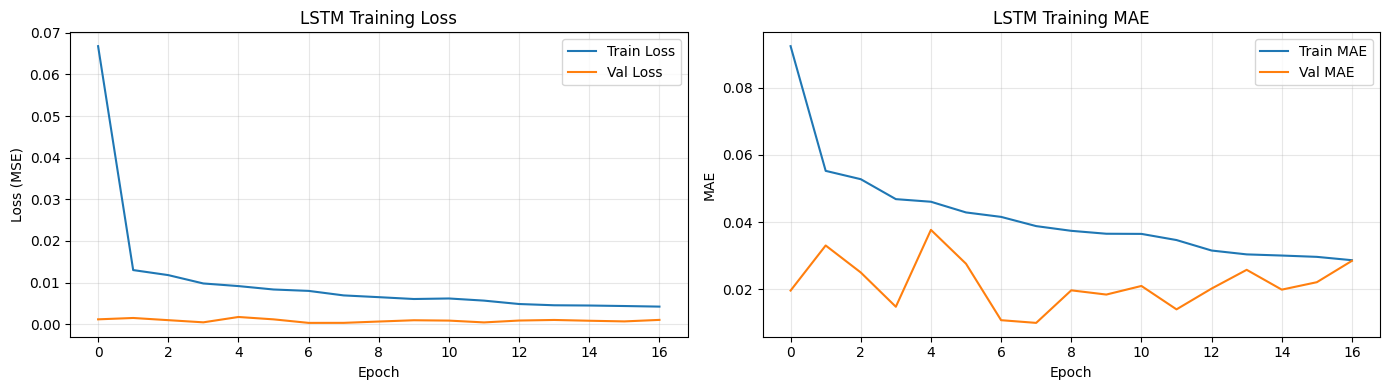


Results for LSTM

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      333.61          1313.34         0.9804    
Day 2      316.06          1225.96         0.9829    
Day 3      361.63          1328.28         0.9800    
Day 4      356.05          1331.63         0.9799    
Day 5      362.06          1345.51         0.9795    
Day 6      375.60          1371.54         0.9787    
Day 7      416.50          1473.85         0.9754    
------------------------------------------------------------
Mean       360.22          1341.44         0.9795    

Training time: 968.32s
Epochs trained: 17
LSTM complete


In [19]:
# LSTM: Deep learning model for sequence forecasting
print("Running LSTM...\n")

with mlflow.start_run(run_name="LSTM"):
    # Hyperparameters
    lstm_units_1 = 128
    lstm_units_2 = 64
    dropout_rate = 0.2
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    
    # Log parameters
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("lstm_units_1", lstm_units_1)
    mlflow.log_param("lstm_units_2", lstm_units_2)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("uses_scaled_targets", True)
    
    start_time = time.time()
    
    # Build model
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, n_features)),
        layers.LSTM(lstm_units_1, return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.LSTM(lstm_units_2),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(HORIZON)  # Output: 7 future closing prices
    ])
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict and INVERSE TRANSFORM back to original scale
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate metrics on original scale
    metrics = calculate_metrics(y_test, y_pred_lstm, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('LSTM Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('LSTM Training MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/tmp/lstm_training_history.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/lstm_training_history.png')
    plt.show()
    
    print_metrics_summary(metrics, "LSTM")
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("LSTM complete")

### 6.2 GRU (Gated Recurrent Unit)

Running GRU...



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 128)        │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,999 (394.53 KB)

 Trainable params: 100,999 (394.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-11-11 17:52:50.049385: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 138695040 exceeds 10% of free system memory.


377/377 ━━━━━━━━━━━━━━━━━━━━ 48s 117ms/step - loss: 0.0636 - mae: 0.1029 - val_loss: 0.0035 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.0134 - mae: 0.0599 - val_loss: 0.0020 - val_mae: 0.0192 - learning_rate: 0.0010
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.0107 - mae: 0.0528 - val_loss: 0.0099 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.0105 - mae: 0.0519 - val_loss: 0.0020 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - loss: 0.0096 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0498 - learning_rate: 0.0010
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - loss: 0.0090 - mae: 0.0463 - val_loss: 0.0025 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0087 - mae: 0.0456
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000

2025/11/11 18:30:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 18:30:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/11 18:30:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/11 18:30:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


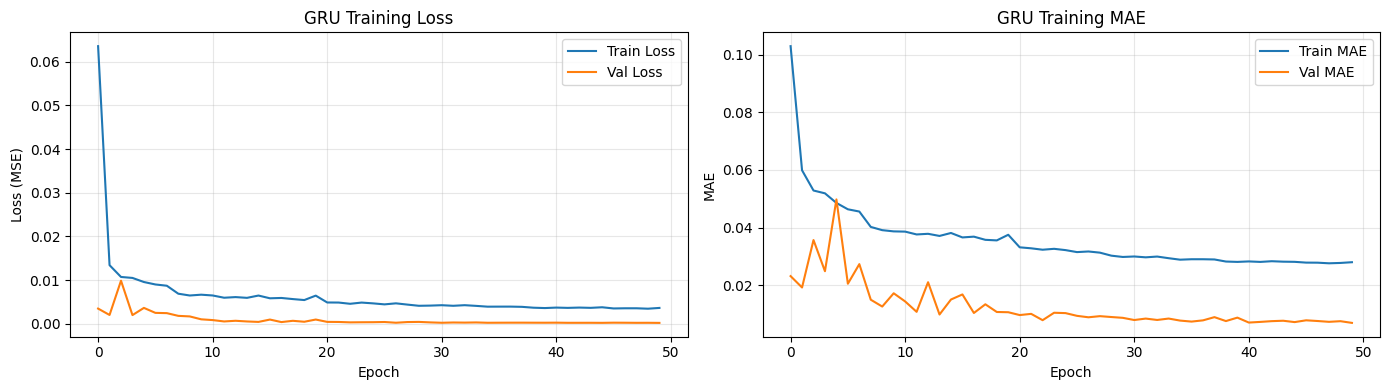


Results for GRU

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      489.93          1964.79         0.9562    
Day 2      490.26          1938.98         0.9573    
Day 3      502.68          1956.78         0.9566    
Day 4      482.87          1855.15         0.9610    
Day 5      520.75          1992.78         0.9550    
Day 6      514.34          1939.56         0.9574    
Day 7      535.95          1990.52         0.9552    
------------------------------------------------------------
Mean       505.26          1948.37         0.9569    

Training time: 2259.71s
Epochs trained: 50
GRU complete


In [20]:
# GRU : Deep learning model for sequence forecasting
print("Running GRU...\n")

with mlflow.start_run(run_name="GRU"):
    # Hyperparameters
    gru_units_1 = 128
    gru_units_2 = 64
    dropout_rate = 0.2
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    
    # Log parameters
    mlflow.log_param("model_type", "GRU")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("gru_units_1", gru_units_1)
    mlflow.log_param("gru_units_2", gru_units_2)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("uses_scaled_targets", True)
    
    start_time = time.time()
    
    # Build model
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, n_features)),
        layers.GRU(gru_units_1, return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.GRU(gru_units_2),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(HORIZON)
    ])
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict and INVERSE TRANSFORM back to original scale
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred_gru = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate metrics on original scale
    metrics = calculate_metrics(y_test, y_pred_gru, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('GRU Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('GRU Training MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/tmp/gru_training_history.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/gru_training_history.png')
    plt.show()
    
    print_metrics_summary(metrics, "GRU")
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("GRU complete")

### 6.3 CNN + LSTM Hybrid

Running CNN+LSTM Hybrid...



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,663 (213.53 KB)

 Trainable params: 54,663 (213.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-11-11 18:36:03.049400: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 138695040 exceeds 10% of free system memory.


377/377 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0756 - mae: 0.1061 - val_loss: 0.0173 - val_mae: 0.0622 - learning_rate: 0.0010
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0165 - mae: 0.0619 - val_loss: 0.0252 - val_mae: 0.0723 - learning_rate: 0.0010
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0139 - mae: 0.0560 - val_loss: 0.0077 - val_mae: 0.0462 - learning_rate: 0.0010
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0118 - mae: 0.0521 - val_loss: 0.0045 - val_mae: 0.0458 - learning_rate: 0.0010
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0114 - mae: 0.0500 - val_loss: 0.0059 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0102 - mae: 0.0470 - val_loss: 0.0046 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0101 - mae: 0.0461 - val_loss: 0.0510 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 8/

2025/11/11 18:38:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 18:38:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/11 18:39:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/11 18:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


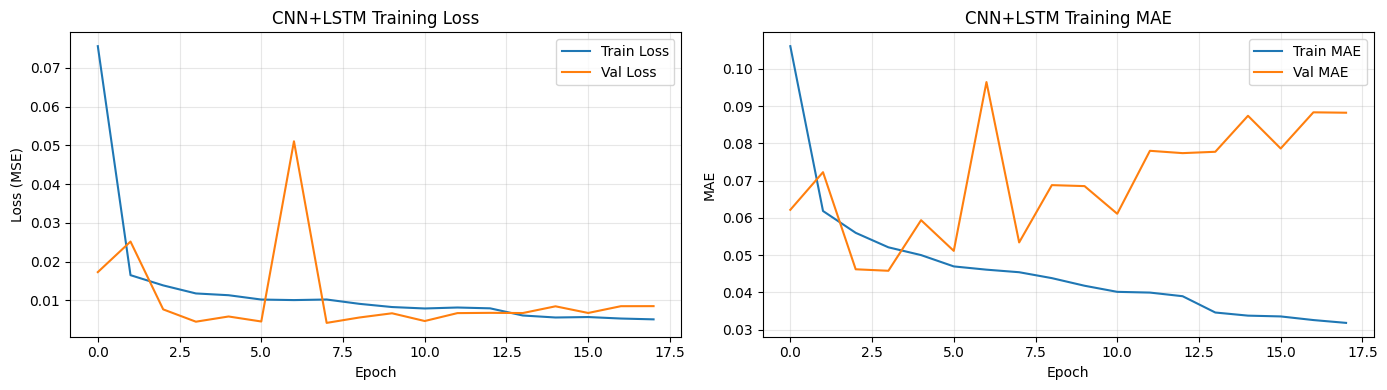


Results for CNN+LSTM Hybrid

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      853.64          2687.84         0.9179    
Day 2      906.72          2763.99         0.9133    
Day 3      873.84          2737.72         0.9150    
Day 4      887.55          2753.91         0.9140    
Day 5      892.46          2825.90         0.9095    
Day 6      920.75          2826.95         0.9095    
Day 7      898.13          2692.96         0.9179    
------------------------------------------------------------
Mean       890.44          2755.61         0.9139    

Training time: 172.00s
Epochs trained: 18
CNN+LSTM Hybrid complete


In [21]:
# CNN+LSTM Hybrid: Combine CNN for feature extraction and LSTM for sequence modeling
print("Running CNN+LSTM Hybrid...\n")

with mlflow.start_run(run_name="CNN_LSTM_Hybrid"):
    # Hyperparameters
    conv_filters = 64
    kernel_size = 3
    lstm_units = 64
    dropout_rate = 0.2
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    
    # Log parameters
    mlflow.log_param("model_type", "CNN_LSTM_Hybrid")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("conv_filters", conv_filters)
    mlflow.log_param("kernel_size", kernel_size)
    mlflow.log_param("lstm_units", lstm_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("uses_scaled_targets", True)
    
    start_time = time.time()
    
    # Build model
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, n_features)),
        
        # CNN layers for local feature extraction
        layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),
        
        layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),
        
        # LSTM for temporal dependencies
        layers.LSTM(lstm_units),
        layers.Dropout(dropout_rate),
        
        # Dense output
        layers.Dense(64, activation='relu'),
        layers.Dense(HORIZON)
    ])
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict and INVERSE TRANSFORM back to original scale
    y_pred_scaled = model.predict(X_test_scaled, verbose=0)
    y_pred_cnn_lstm = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate metrics on original scale
    metrics = calculate_metrics(y_test, y_pred_cnn_lstm, HORIZON)
    log_metrics_to_mlflow(metrics)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('CNN+LSTM Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('CNN+LSTM Training MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/tmp/cnn_lstm_training_history.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/cnn_lstm_training_history.png')
    plt.show()
    
    print_metrics_summary(metrics, "CNN+LSTM Hybrid")
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("CNN+LSTM Hybrid complete")

---
## 7. Prophet (Per-Stock Time Series Baseline)

**Note**: Prophet trains separately for each stock, so it's not directly comparable to stock-agnostic models. We include it as a per-stock baseline.

In [22]:
# Prophet: Facebook's time series forecasting tool
# Note: Prophet trains per-stock (not stock-agnostic)
# We'll train Prophet for a few test stocks and average the results

print("Running Prophet (per-stock baseline)...\n")
print("Note: Prophet trains separately for each stock (not stock-agnostic)\n")

with mlflow.start_run(run_name="Prophet_PerStock"):
    # Log parameters
    mlflow.log_param("model_type", "Prophet")
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("per_stock_training", True)
    mlflow.log_param("n_test_stocks", len(test_symbols))
    
    start_time = time.time()
    
    # Store predictions for all test stocks
    all_y_true = []
    all_y_pred = []
    
    # Train Prophet for first 5 test stocks (for speed)
    for i, symbol in enumerate(test_symbols[:5]):
        print(f"\nProcessing {i+1}/5: {symbol}...")
        
        # Get full stock data
        df = stock_data[symbol][['Date', 'Close']].copy()
        df.columns = ['ds', 'y']  # Prophet requires these column names

        # Remove timezone from datetime column (Prophet doesn't support timezones)
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
        
        # Split: use 90% for training, last 10% for testing
        split_idx = int(len(df) * 0.9)
        train_df = df[:split_idx]
        test_df = df[split_idx:]
        
        # Only proceed if we have enough test data
        if len(test_df) < HORIZON:
            continue
        
        # Train Prophet
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.05
        )
        model.fit(train_df)
        
        # Make predictions for test period
        future = model.make_future_dataframe(periods=len(test_df), freq='D')
        forecast = model.predict(future)
        
        # Extract predictions for test period
        test_forecast = forecast.iloc[split_idx:][['yhat']].values.flatten()
        
        # Create 7-day sequences from test data
        for j in range(len(test_df) - HORIZON + 1):
            y_true_seq = test_df['y'].iloc[j:j+HORIZON].values
            y_pred_seq = test_forecast[j:j+HORIZON]
            
            all_y_true.append(y_true_seq)
            all_y_pred.append(y_pred_seq)
    
    train_time = time.time() - start_time
    
    # Convert to arrays
    y_true_prophet = np.array(all_y_true)
    y_pred_prophet = np.array(all_y_pred)
    
    # Calculate metrics
    if len(y_true_prophet) > 0:
        metrics = calculate_metrics(y_true_prophet, y_pred_prophet, HORIZON)
        log_metrics_to_mlflow(metrics)
        mlflow.log_metric("train_time_seconds", train_time)
        mlflow.log_metric("stocks_evaluated", 5)
        
        print_metrics_summary(metrics, "Prophet (Per-Stock)")
        print(f"Training time: {train_time:.2f}s")
        print(f"Stocks evaluated: 5")
        print(f"Total test samples: {len(y_true_prophet)}")
    else:
        print("No valid predictions from Prophet")

print("\nProphet complete")

Running Prophet (per-stock baseline)...

Note: Prophet trains separately for each stock (not stock-agnostic)


Processing 1/5: TORNTPHARM...


18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing



Processing 2/5: HAL...


18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing



Processing 3/5: DLF...


18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing



Processing 4/5: ABB...


18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing



Processing 5/5: IOC...

Results for Prophet (Per-Stock)

Day        MAE             RMSE            R²        
------------------------------------------------------------
Day 1      215.61          363.10          0.9690    
Day 2      222.59          372.93          0.9674    
Day 3      228.79          380.79          0.9661    
Day 4      235.81          388.88          0.9647    
Day 5      241.93          395.93          0.9635    
Day 6      247.48          402.13          0.9623    
Day 7      254.26          409.18          0.9611    
------------------------------------------------------------
Mean       235.21          387.56          0.9649    

Training time: 2.79s
Stocks evaluated: 5
Total test samples: 195

Prophet complete


---
## 8. Results Summary & Comparison

### 8.1 Query MLflow Experiments

In [23]:
# Retrieve all runs from the experiment
experiment = mlflow.get_experiment_by_name("stock-price-forecasting-7days")
runs_df = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.mean_rmse ASC"]
)

print(f"Total runs: {len(runs_df)}\n")

# Select relevant columns for comparison
summary_cols = [
    'tags.mlflow.runName',
    'metrics.mean_mae',
    'metrics.mean_rmse',
    'metrics.mean_r2',
    'metrics.train_time_seconds'
]

summary_df = runs_df[summary_cols].copy()
summary_df.columns = ['Model', 'Mean MAE', 'Mean RMSE', 'Mean R²', 'Train Time (s)']
summary_df = summary_df.sort_values('Mean RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON - Ranked by Mean RMSE (Lower is Better)")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Highlight best model
best_model = summary_df.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"   Mean MAE:  {best_model['Mean MAE']:.2f}")
print(f"   Mean RMSE: {best_model['Mean RMSE']:.2f}")
print(f"   Mean R²:   {best_model['Mean R²']:.4f}")
print(f"   Train Time: {best_model['Train Time (s)']:.2f}s")

Total runs: 8


MODEL COMPARISON - Ranked by Mean RMSE (Lower is Better)
                 Model   Mean MAE   Mean RMSE  Mean R²  Train Time (s)
        Naive_Baseline 113.179638  320.469739 0.998757        0.000552
     Linear_Regression 123.365035  344.035417 0.998562       75.034079
      Prophet_PerStock 235.210305  387.562869 0.964872        2.793466
                  LSTM 360.216250 1341.443997 0.979546      968.319370
RandomForest_Optimized 368.079964 1410.591799 0.977405       43.548965
                   GRU 505.256163 1948.365953 0.956937     2259.713543
     XGBoost_Optimized 592.554268 2159.938864 0.947079       60.249869
       CNN_LSTM_Hybrid 890.441985 2755.609314 0.913873      172.002860

BEST MODEL: Naive_Baseline
   Mean MAE:  113.18
   Mean RMSE: 320.47
   Mean R²:   0.9988
   Train Time: 0.00s


### 8.2 Visualize Model Performance

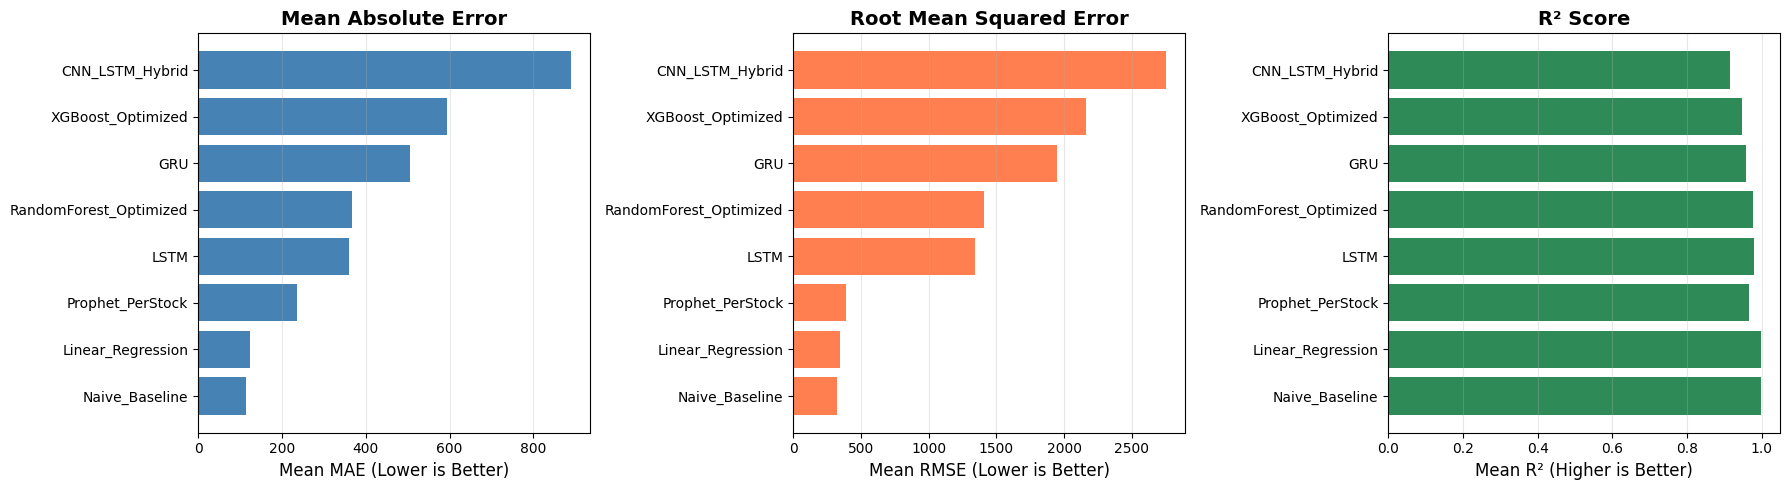

Model comparison chart saved


In [24]:
# Bar chart comparing models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
axes[0].barh(summary_df['Model'], summary_df['Mean MAE'], color='steelblue')
axes[0].set_xlabel('Mean MAE (Lower is Better)', fontsize=12)
axes[0].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
axes[1].barh(summary_df['Model'], summary_df['Mean RMSE'], color='coral')
axes[1].set_xlabel('Mean RMSE (Lower is Better)', fontsize=12)
axes[1].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# R² comparison
axes[2].barh(summary_df['Model'], summary_df['Mean R²'], color='seagreen')
axes[2].set_xlabel('Mean R² (Higher is Better)', fontsize=12)
axes[2].set_title('R² Score', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model comparison chart saved")

### 8.3 Error by Prediction Horizon

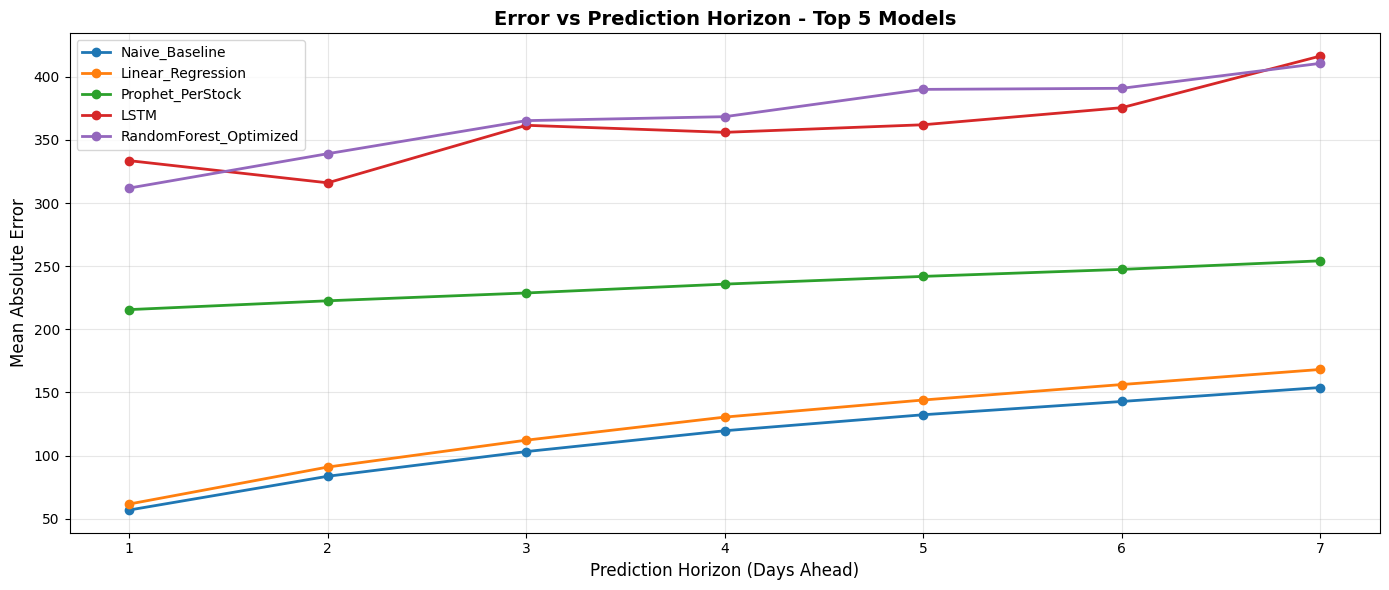

Error by horizon chart saved

Insight: Error typically increases with longer prediction horizons


In [25]:
# Plot MAE for each day (1-7) across all models
plt.figure(figsize=(14, 6))

# Get top 5 models by mean RMSE
top_models = summary_df.head(5)['Model'].tolist()

for model_name in top_models:
    # Find run for this model
    run = runs_df[runs_df['tags.mlflow.runName'] == model_name].iloc[0]
    
    # Extract day-wise MAE
    mae_by_day = [run[f'metrics.mae_day{i}'] for i in range(1, 8)]
    
    plt.plot(range(1, 8), mae_by_day, marker='o', linewidth=2, label=model_name)

plt.xlabel('Prediction Horizon (Days Ahead)', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('Error vs Prediction Horizon - Top 5 Models', fontsize=14, fontweight='bold')
plt.xticks(range(1, 8))
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/tmp/error_by_horizon.png', dpi=150, bbox_inches='tight')
plt.show()

print("Error by horizon chart saved")
print("\nInsight: Error typically increases with longer prediction horizons")

### 8.4 Visualize Sample Predictions

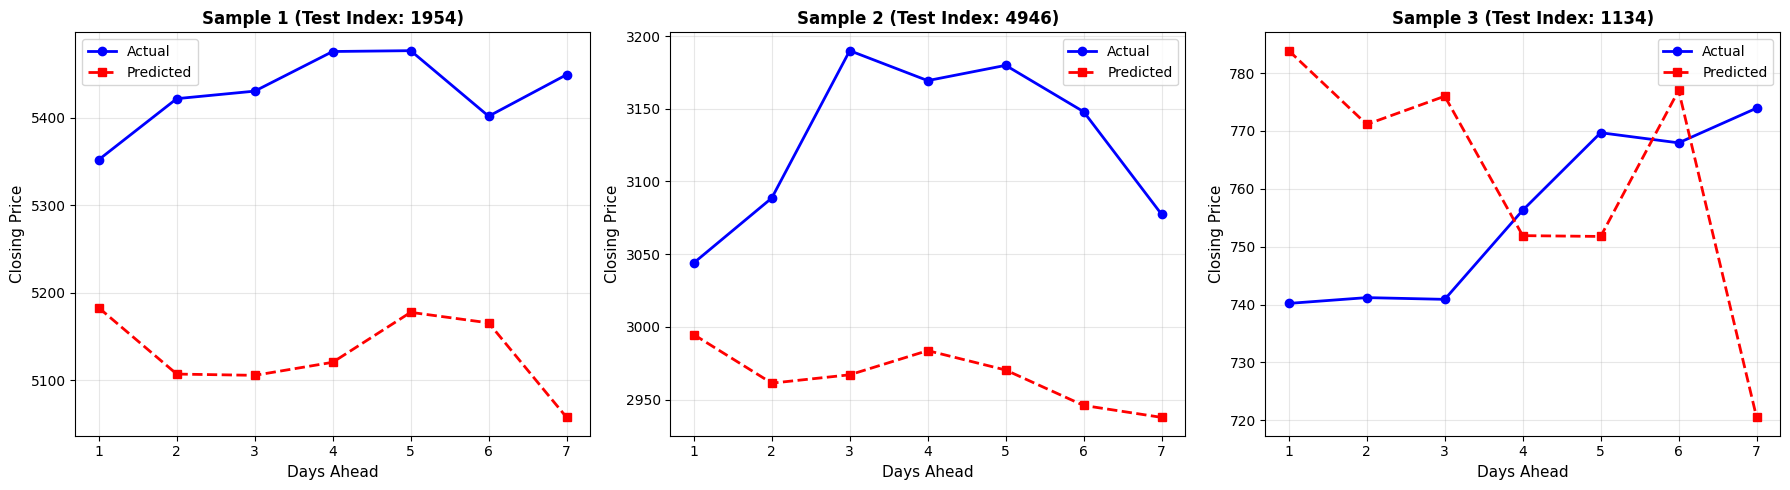

Sample predictions visualization saved


In [26]:
# Visualize predictions for 3 random test samples
sample_indices = np.random.choice(len(y_test), size=3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use LSTM predictions (or your best model)
y_pred_best = y_pred_lstm

for idx, sample_idx in enumerate(sample_indices):
    ax = axes[idx]
    
    days = np.arange(1, 8)
    y_true_sample = y_test[sample_idx]
    y_pred_sample = y_pred_best[sample_idx]
    
    ax.plot(days, y_true_sample, marker='o', linewidth=2, label='Actual', color='blue')
    ax.plot(days, y_pred_sample, marker='s', linewidth=2, label='Predicted', color='red', linestyle='--')
    
    ax.set_xlabel('Days Ahead', fontsize=11)
    ax.set_ylabel('Closing Price', fontsize=11)
    ax.set_title(f'Sample {idx+1} (Test Index: {sample_idx})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(days)

plt.tight_layout()
plt.savefig('/tmp/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions visualization saved")

### 8.5 Query Best Model from MLflow

In [27]:
# Query the best run (lowest mean RMSE)
best_run = runs_df.sort_values('metrics.mean_rmse').iloc[0]

print("\n" + "="*80)
print("BEST MODEL DETAILS")
print("="*80)
print(f"Run Name:       {best_run['tags.mlflow.runName']}")
print(f"Run ID:         {best_run['run_id']}")
print(f"\nMetrics:")
print(f"  Mean MAE:     {best_run['metrics.mean_mae']:.2f}")
print(f"  Mean RMSE:    {best_run['metrics.mean_rmse']:.2f}")
print(f"  Mean R²:      {best_run['metrics.mean_r2']:.4f}")
print(f"\nParameters:")
param_cols = [col for col in best_run.index if col.startswith('params.')]
for param in param_cols:
    param_name = param.replace('params.', '')
    param_value = best_run[param]
    if pd.notna(param_value):
        print(f"  {param_name}: {param_value}")
print("="*80)

# Load model example
best_run_id = best_run['run_id']
print(f"\nTo load this model:")
print(f"   model_uri = 'runs:/{best_run_id}/model'")
print(f"   loaded_model = mlflow.sklearn.load_model(model_uri)  # or mlflow.keras")


BEST MODEL DETAILS
Run Name:       Naive_Baseline
Run ID:         461eaa53c4694bbbb9826f9ff33dcd53

Metrics:
  Mean MAE:     113.18
  Mean RMSE:    320.47
  Mean R²:      0.9988

Parameters:
  window_size: 60
  horizon: 7
  model_type: Naive

To load this model:
   model_uri = 'runs:/461eaa53c4694bbbb9826f9ff33dcd53/model'
   loaded_model = mlflow.sklearn.load_model(model_uri)  # or mlflow.keras


---
## Summary & Next Steps

### Key Findings:


### Model Insights:


### Next Steps:


### MLflow UI:
```bash
# Launch MLflow UI to explore experiments
cd <"project_directory">
uv run mlflow ui --port 5000
# Visit: http://localhost:5000
```

---

**Notebook Complete!** All models trained and evaluated with MLflow tracking.